#### Импорт и константы

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tqdm import tqdm
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy import stats
import statsmodels.api as sm
from itertools import product
import warnings

import holidays

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
PATH_TO_DATA = '/content/drive/MyDrive/Colab Notebooks/taxi/'
long = [-74.25559, -73.70001]
lat = [40.49612, 40.91553]
ESB = [-73.985428, 40.748817]
ESB_zone = int((ESB[0] - long[0]) // ((long[1] - long[0]) / 50) * 50 + (ESB[1] - lat[0]) // ((lat[1]-lat[0]) / 50)) + 1

#### Вспомагательные функции

In [5]:
def load_pickles(start, end, zone):
    """
    format YYYY-MM, start included, end - not
    """
    res = pd.Series(dtype=np.float64)
    for d in tqdm(pd.date_range(start, end, freq='M')):
        with open(os.path.join(PATH_TO_DATA, f'pickles/yellow_tripdata_{d.year}-{d.month:02}.pkl'), 'rb') as f:
            df = pickle.load(f)
            #print(type(df[zone]))
        res = res.append(df[zone])
    return res
            

In [6]:
def add_feature(T, K, seasons = [168], trend = False):
    if type(seasons) == int: seasons = [seasons]
    res=np.empty((T, 2*K*len(seasons)+trend))
    for i, season in enumerate(seasons):
        arr = 2 * np.pi * np.outer(np.arange(1, T+1), np.arange(1, K+1)) / season
        res[:, 2*K*i: 2*K*i+K] = np.sin(arr)
        res[:, 2*K*i+K:2*K*i+2*K] = np.cos(arr)
    if trend: res[:, -1] = np.arange(1, T+1)
    return res

In [7]:
def add_holidays(y):
    holidays_NY = holidays.CountryHoliday('US', state='NY', years=[2015, 2016])
    holidays_NY = pd.Series(holidays_NY.values(), index=holidays_NY.keys()).sort_index()
    holidays_NY.index = pd.to_datetime(holidays_NY.index)
    holidays_NY = holidays_NY.loc[y.index.min(): y.index.max()]
    res = pd.DataFrame(np.zeros((y.shape[0], holidays_NY.nunique())),
                 index=y.index, columns=holidays_NY.unique())
    for index, holiday in holidays_NY.items():
        res.loc[index.strftime('%Y-%m-%d'), holiday] = 1
    return res

# def add_holidays(y):
#     holidays_NY = holidays.CountryHoliday('US', state='NY', years=[2013, 2016])
#     holidays_NY = pd.Series(holidays_NY.values(), index=holidays_NY.keys()).sort_index()
#     holidays_NY.index = pd.to_datetime(holidays_NY.index)
#     holidays_NY = holidays_NY.loc[y.index.min(): y.index.max()]
#     columns = list(holidays_NY.unique()) + [s+'_'+ba for s in holidays_NY.unique() for ba in 'ba']
#     res = pd.DataFrame(np.zeros((y.shape[0], 3*holidays_NY.nunique())),
#                  index=y.index, columns=columns)
#     for index, holiday in holidays_NY.items():
#         res.loc[index.strftime('%Y-%m-%d'), holiday] = 1
#         before = (index - pd.Timedelta('1d')).strftime('%Y-%m-%d')
#         after = (index + pd.Timedelta('1d')).strftime('%Y-%m-%d')
#         res.loc[before, holiday+'_b'] = 1
#         res.loc[after, holiday+'_a'] = 1
#     return res

#### Загрузим данные за 6 месяцев для зоны 1231

In [8]:
y = load_pickles('2015-12', '2016-06', 1231)

100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


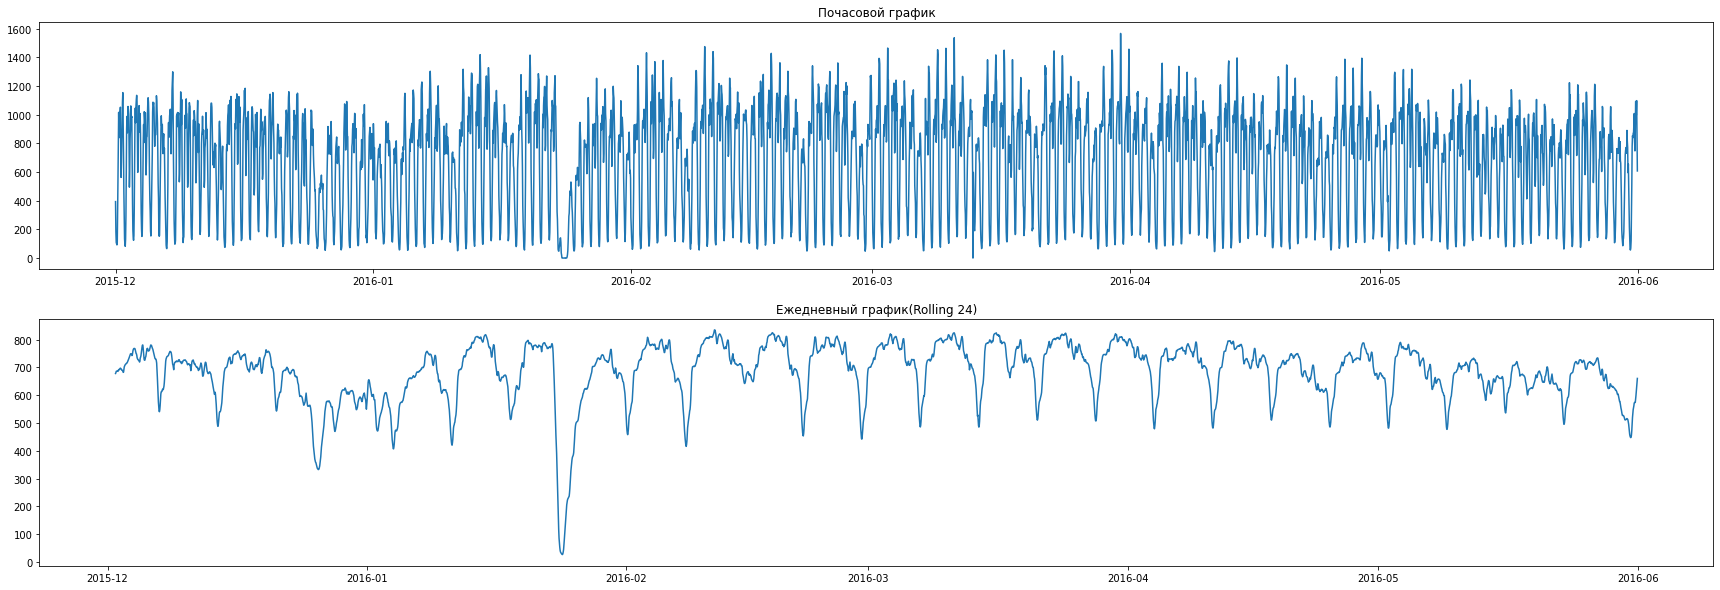

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(30, 10))
fig = ax[0].plot(y)
ax[0].set_title('Почасовой график')
fig = ax[1].plot(y.rolling(24).mean())
ax[1].set_title('Ежедневный график(Rolling 24)');
# fig = ax[2].plot(y.resample('D').sum())
# ax[2].set_title('Ежедневный график');

#### Создаем регрессионные признаки для учёта недельной сезонности и тренда. Создаем регрессию на построенные признаки. Считем остатки линейной модели.

In [ ]:
k=5
X = add_feature(y.shape[0], k, [168], trend=False)
lr = LinearRegression()
lr.fit(X, y)
resid = y - lr.predict(X)
print(f'Mean absolute error for y = {resid.abs().mean():.2f}')

Mean absolute error for y = 295.41


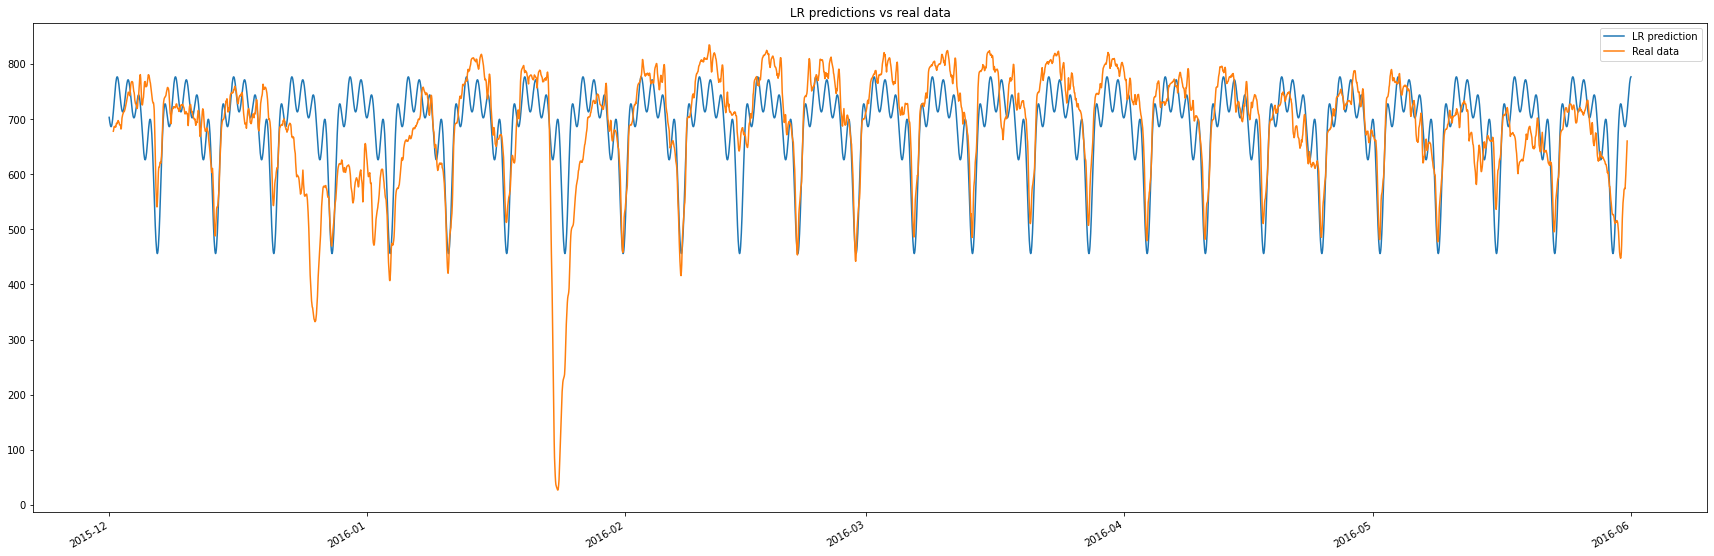

In [ ]:
fig = plt.figure(figsize=(30,10))
plt.plot(y.index, lr.predict(X), label='LR prediction')
y.rolling(24, center=True).mean().plot(label='Real data', title='LR predictions vs real data')
plt.legend();

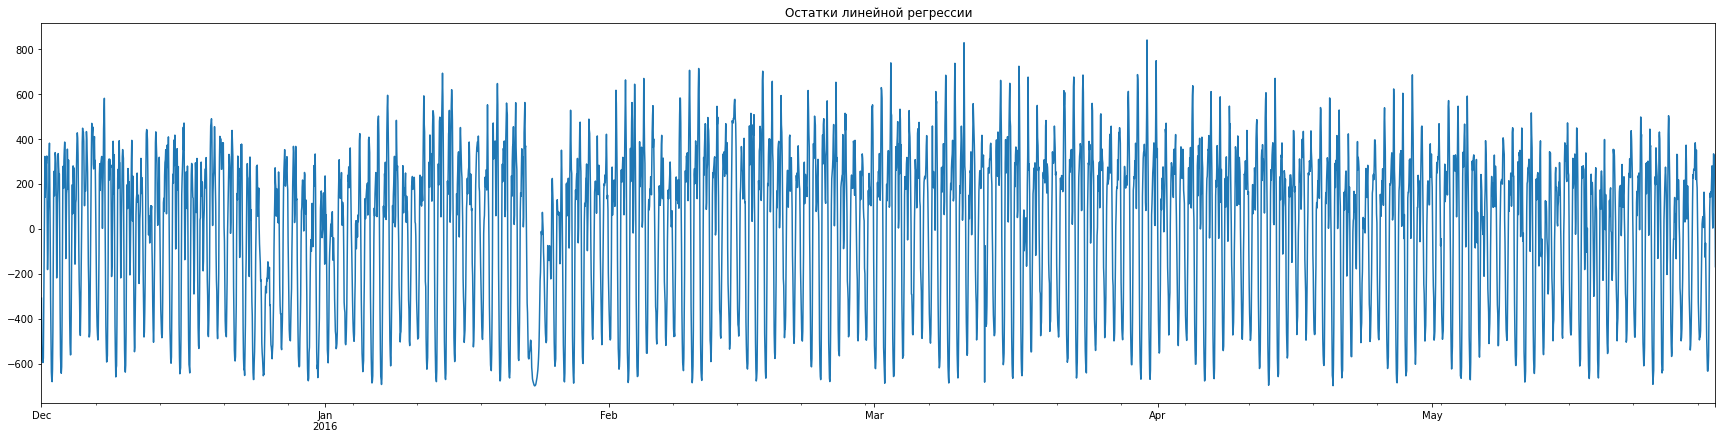

In [ ]:
fig = plt.figure(figsize=(30,7))
resid.plot(title='Остатки линейной регрессии');

#### Стационарность остатков

Дисперсия остатков ЛР выглядит равномерной. Проверим это, убедившись, что ламбда оптимального преобразования Бокса-Кокса близка в 1.

In [ ]:
stats.boxcox(resid-resid.min()+1)[1].round(4)

1.0005

Критерий Дики-Фуллера близок к нулю, поэтому смотрим на STL-декомпозицию остатков. 

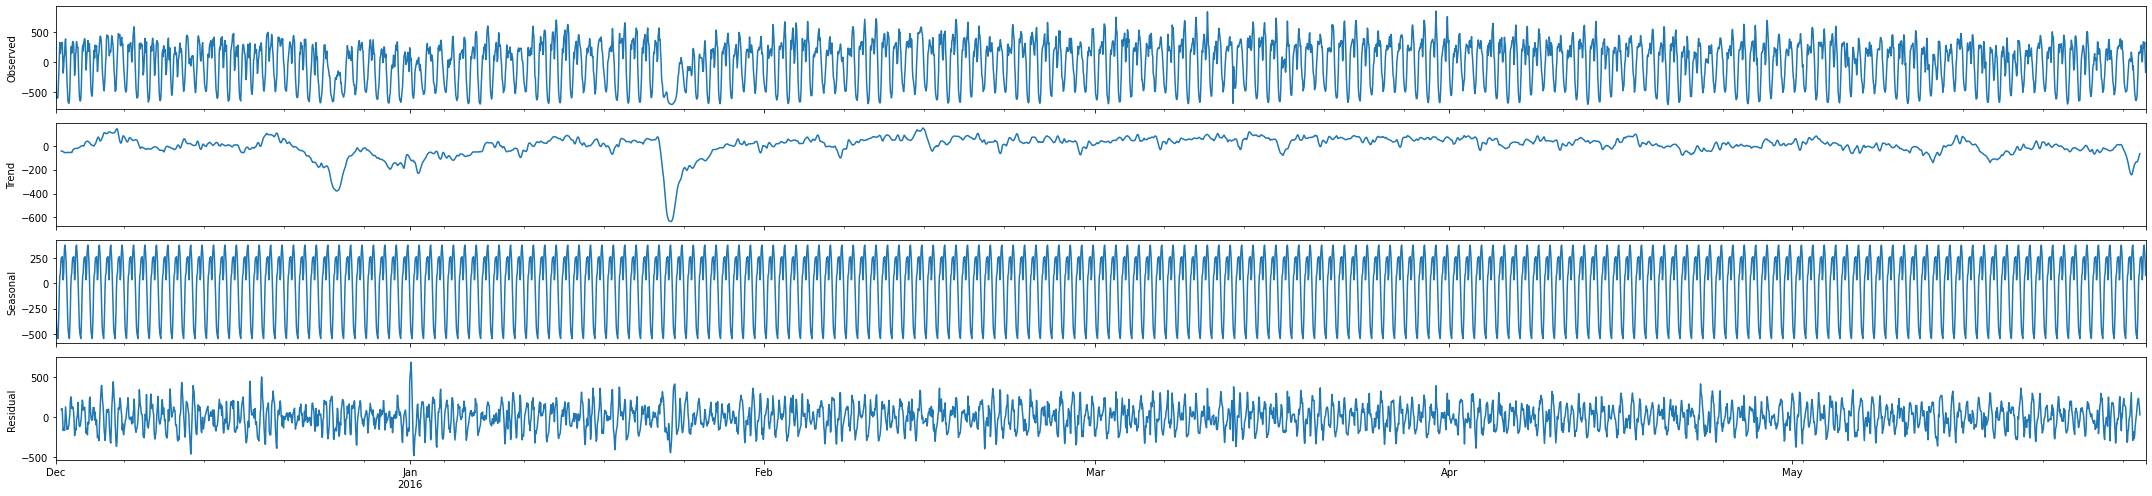

In [ ]:
plt.rcParams['figure.figsize'] = 30, 7
sm.tsa.seasonal_decompose(resid).plot();

С помощью дифференциирования пробуем сделать ряд стационарным.

				После дневного(24 часа) дифференциирования


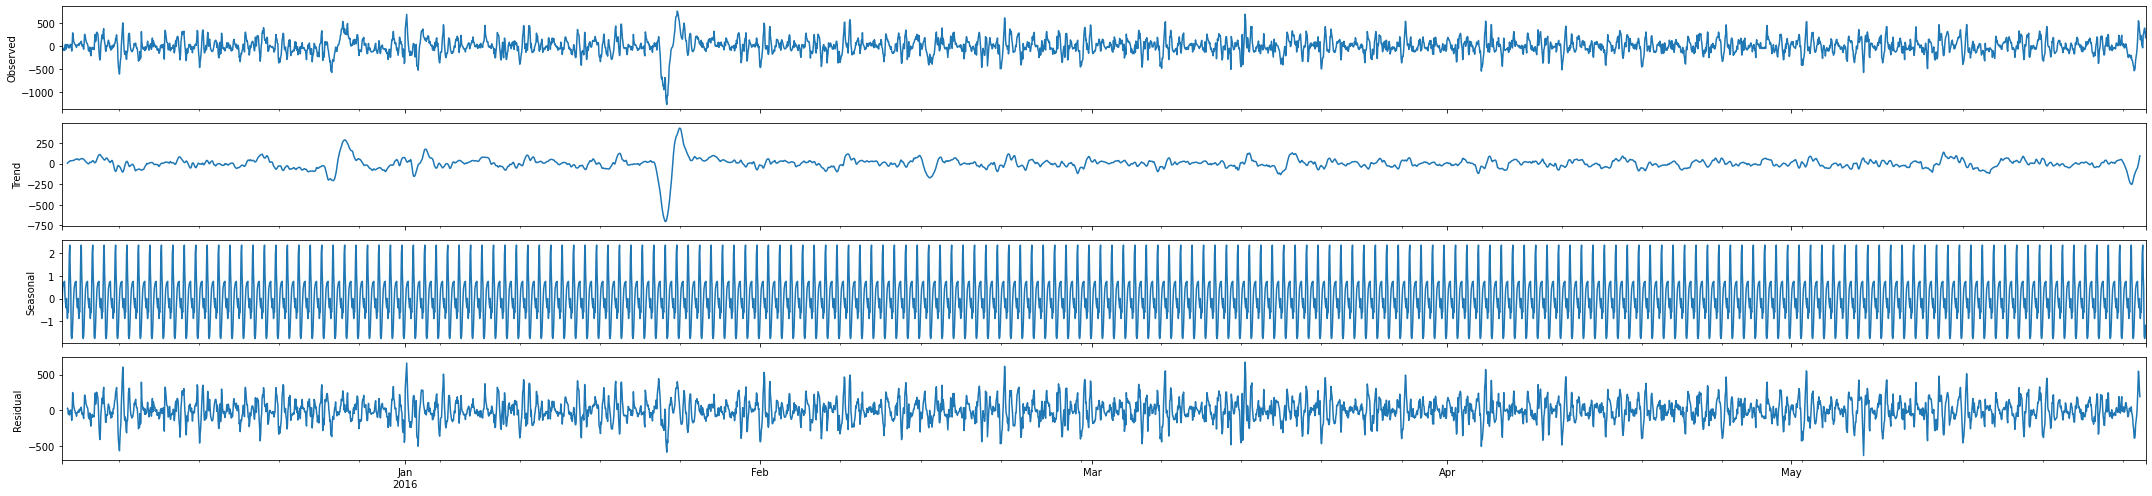

In [ ]:
# plt.rcParams['figure.figsize'] = 30, 7
print('\t\t\t\tПосле дневного(24 часа) дифференциирования')
sm.tsa.seasonal_decompose(resid.diff(24).dropna()).plot();

				После простого дифференциирования


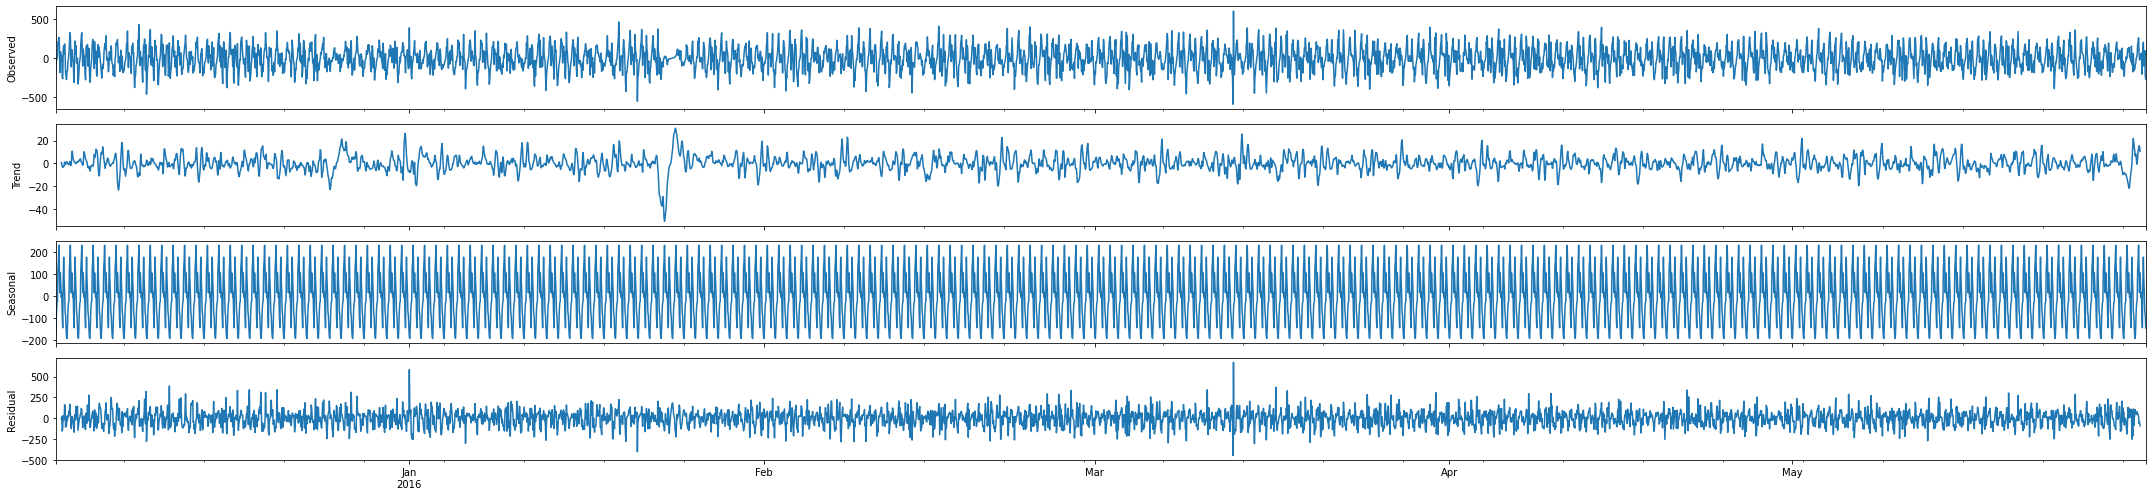

In [ ]:
# plt.rcParams['figure.figsize'] = 30, 7
print('\t\t\t\tПосле простого дифференциирования')
sm.tsa.seasonal_decompose(resid.diff().dropna()).plot();

				После дневного + часового дифференциирования


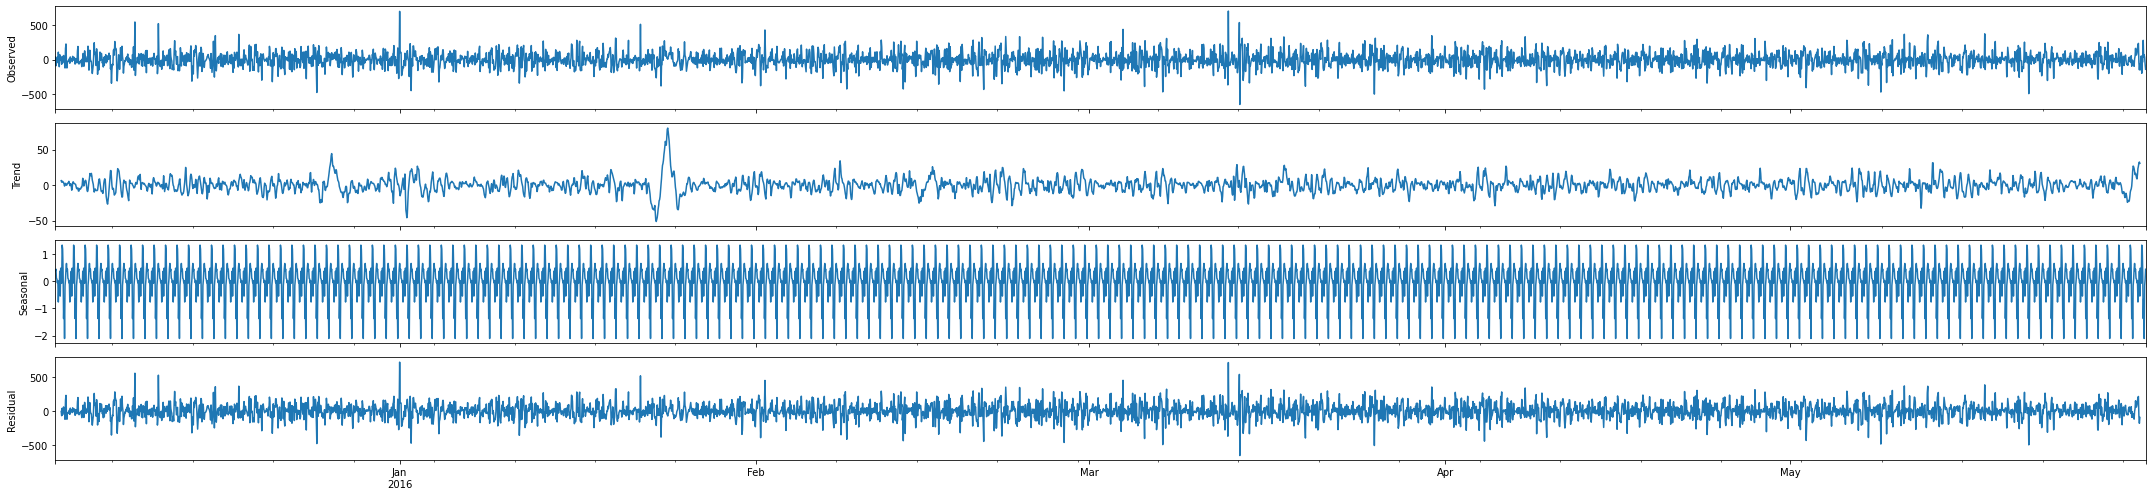

In [ ]:
# plt.rcParams['figure.figsize'] = 30, 7
print('\t\t\t\tПосле дневного + часового дифференциирования')
sm.tsa.seasonal_decompose(resid.diff(24).diff().dropna()).plot();

Критерий Дики-Фуллера во всех слючаях показывает стационарность. Визуально однозначно выбрать какой-либо вариант сложно. Посмотрим на ACF/PACF разных вариантов

#### Подбор модели

Посмотрим на ACF и PACF рядов:

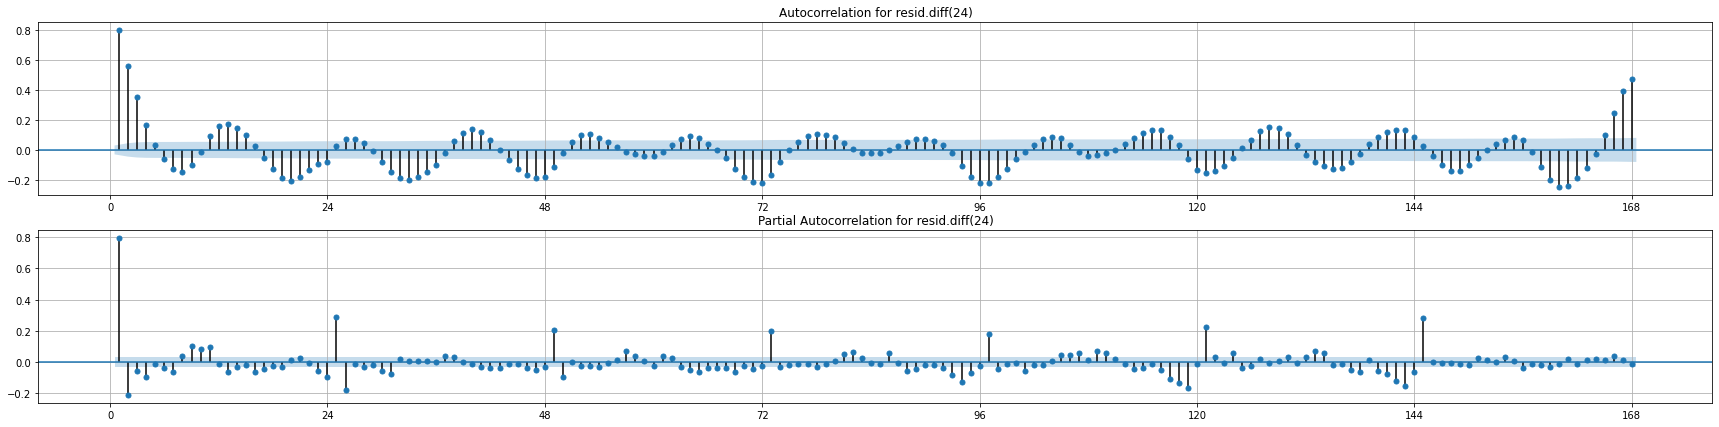

In [ ]:
resid_diff = resid.diff(24).dropna()

fig,ax = plt.subplots(2,1,figsize=(30,7))
fig = sm.graphics.tsa.plot_acf(resid_diff.values.squeeze(), lags=168, ax=ax[0], zero=False, title='Autocorrelation for resid.diff(24)')
ax[0].grid( True )
ax[0].set_xticks(np.arange(0, 169,24))
fig = sm.graphics.tsa.plot_pacf(resid_diff.values.squeeze(), lags=168, ax=ax[1], method='ywm', zero=False, title='Partial Autocorrelation for resid.diff(24)')
ax[1].grid( True )
ax[1].set_xticks(np.arange(0, 169,24))
plt.show()

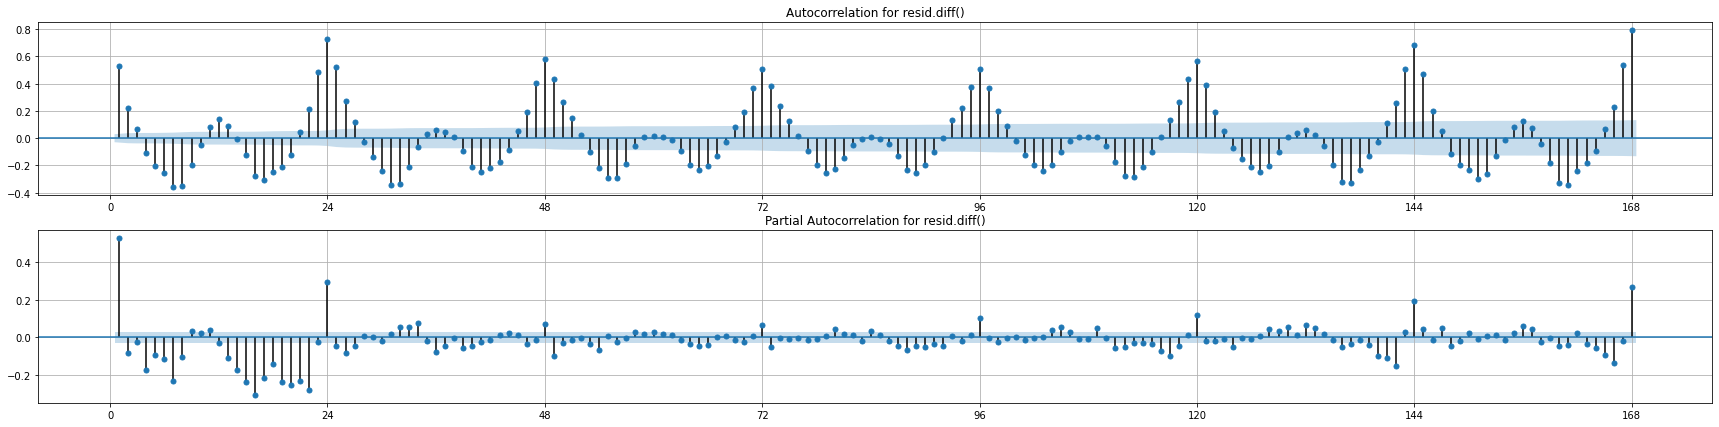

In [ ]:
resid_diff = resid.diff().dropna()

fig,ax = plt.subplots(2,1,figsize=(30,7))
fig = sm.graphics.tsa.plot_acf(resid_diff.values.squeeze(), lags=168, ax=ax[0], zero=False, title='Autocorrelation for resid.diff()')
ax[0].grid( True )
ax[0].set_xticks(np.arange(0, 169,24))
fig = sm.graphics.tsa.plot_pacf(resid_diff.values.squeeze(), lags=168, ax=ax[1], method='ywm', zero=False, title='Partial Autocorrelation for resid.diff()')
ax[1].grid( True )
ax[1].set_xticks(np.arange(0, 169,24))
plt.show()

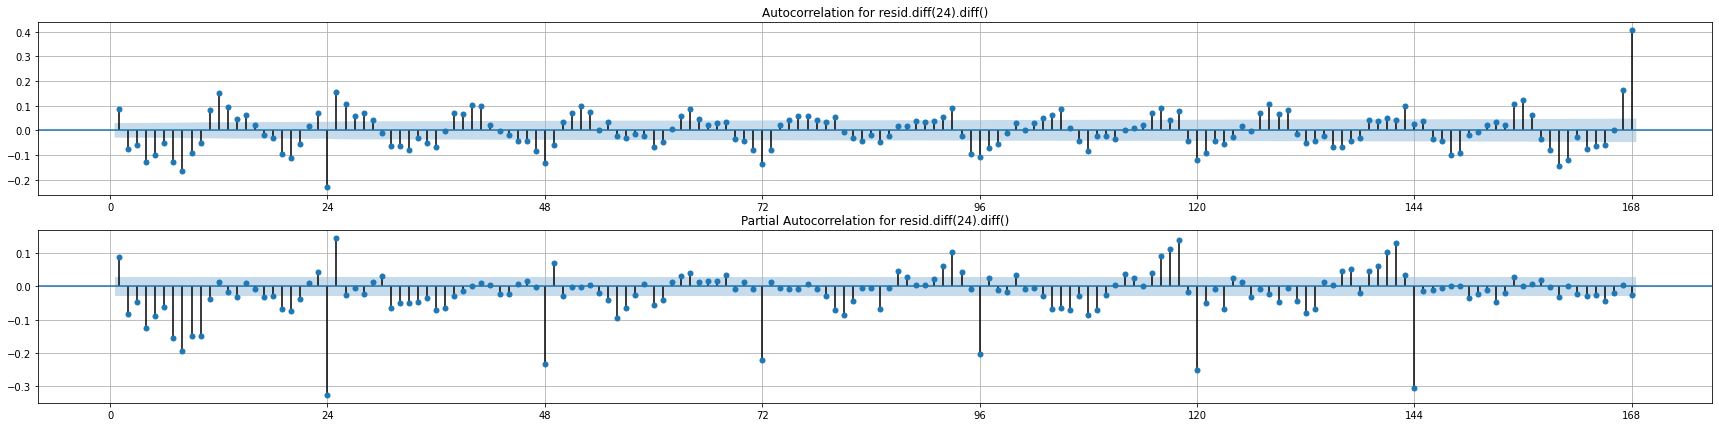

In [ ]:
resid_diff = resid.diff(24).diff().dropna()

fig,ax = plt.subplots(2,1,figsize=(30,7))
fig = sm.graphics.tsa.plot_acf(resid_diff.values.squeeze(), lags=168, ax=ax[0], zero=False, title='Autocorrelation for resid.diff(24).diff()')
ax[0].grid( True )
ax[0].set_xticks(np.arange(0, 169,24))
fig = sm.graphics.tsa.plot_pacf(resid_diff.values.squeeze(), lags=168, ax=ax[1], method='ywm', zero=False, title='Partial Autocorrelation for resid.diff(24).diff()')
ax[1].grid( True )
ax[1].set_xticks(np.arange(0, 169,24))
plt.show()

Задать начальные приближения и сделать перебор занимает очень много времени. Подбор параметров делался в несколько подходов. Оптимальными выглядят эти: Q=1, q=1, P=1, p=7
Проверить большие значения Q не получилось, не хватало времени.

In [ ]:
ps = [7]
d=1
qs = [1]
Ps = [2]
D=1
Qs = [1]

In [ ]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

1

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(resid, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        enforce_invertibility=False, enforce_stationarity=False).fit(disp=False)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 32min 1s, sys: 11min 1s, total: 43min 2s
Wall time: 21min 56s


In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
0  (7, 4, 2, 1)  50427.782626


Лучшая модель:

In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 4392
Model:             SARIMAX(7, 1, 1)x(2, 1, 1, 24)   Log Likelihood              -25106.471
Date:                            Wed, 19 May 2021   AIC                          50236.943
Time:                                    15:57:47   BIC                          50313.373
Sample:                                12-01-2015   HQIC                         50263.932
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9335      0.013     69.390      0.000       0.907       0.960
ar.L2         -0.1435      0.018   

Её остатки:

Критерий Стьюдента: p=0.866917
Критерий Дики-Фуллера: p=0.000000


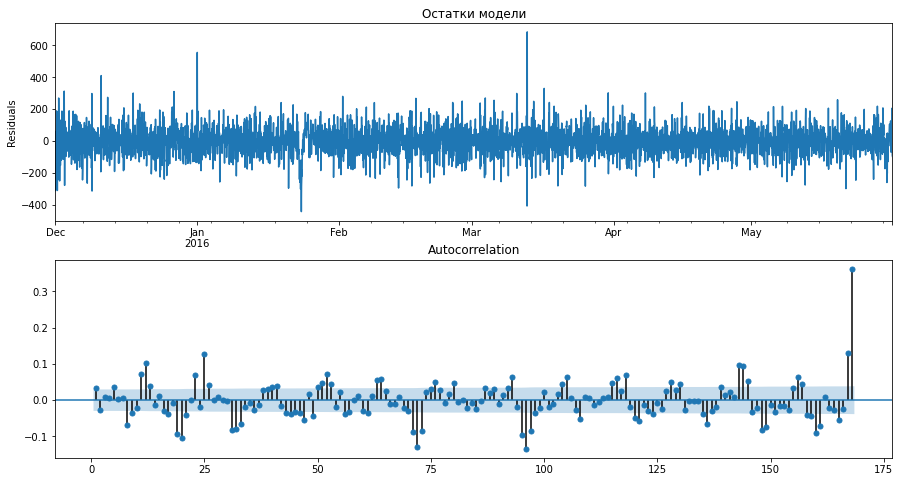

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid.plot(title='Остатки модели')
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=168, zero=False, ax=ax, title='Autocorrelation')

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Остатки несмещены (подтверждается критерием Стьюдента), не совсемь стационарны, есть выбросы и автокоррелированы (подтверждается критерием Льюнга-Бокса (Prob(Q) = 0) и коррелограммой).
Для улучшений нужно будет учесть праздники и природные катаклизмы. Неплохо было бы добавить погоду.
Посмотрим, насколько хорошо модель описывает данные:

In [ ]:
mean_absolute_error(best_model.fittedvalues, y)

62.46717000387059

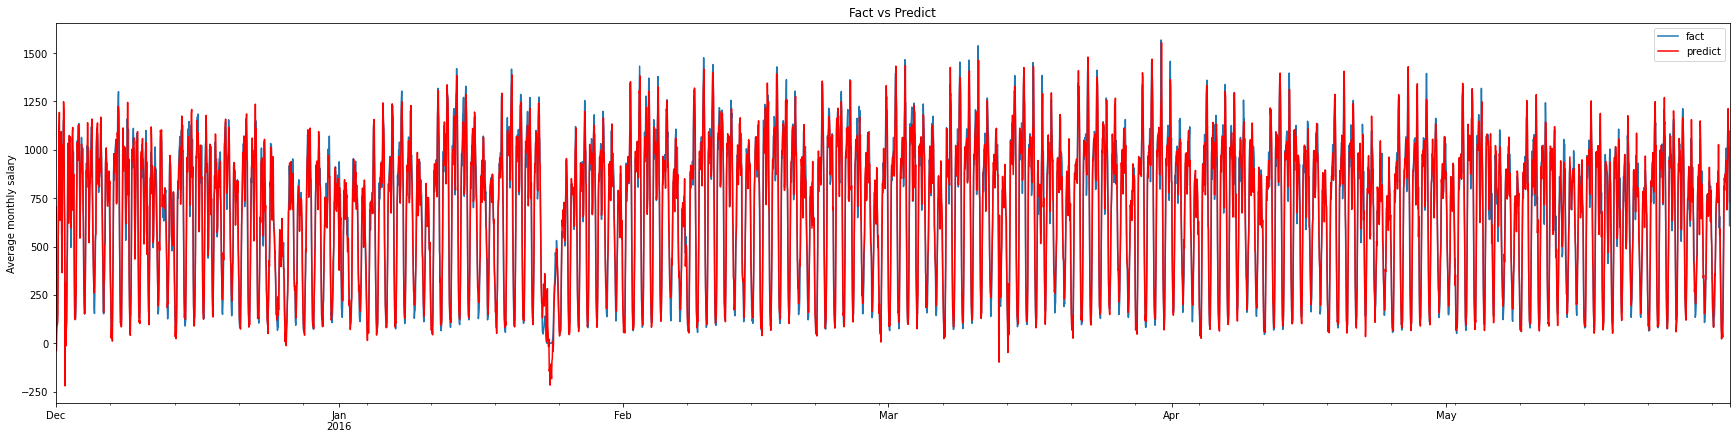

In [ ]:

plt.figure(figsize=(30,7))
y.plot(label = 'fact')
model.fittedvalues.plot(color='r', label = 'predict', title='Fact vs Predict')
plt.ylabel('Average monthly salary')
plt.legend()
plt.show()

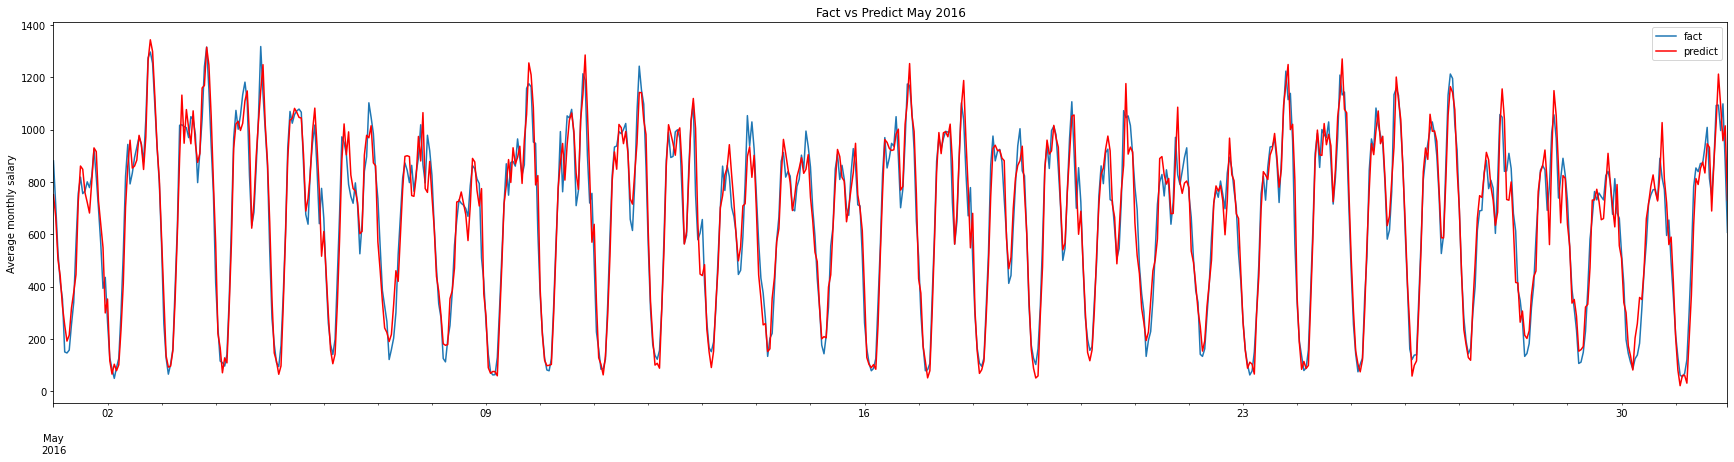

In [ ]:
plt.figure(figsize=(30,7))
y.iloc[-744:].plot(label = 'fact')
model.fittedvalues.iloc[-744:].plot(color='r', label = 'predict', title='Fact vs Predict May 2016')
plt.ylabel('Average monthly salary')
plt.legend()
plt.show()

### Добавим регрессионных признаков

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso, Ridge

In [11]:
k=14
X = add_feature(y.shape[0], k, [168], trend=False)
# add day of month
enc = OneHotEncoder(sparse=False)
week = enc.fit_transform(y.index.isocalendar().week.to_numpy().reshape(-1, 1), )
dayofweek = enc.fit_transform(y.index.day.to_numpy().reshape(-1, 1), )
X = np.hstack([X, week, dayofweek])
# snow
snow = pd.DataFrame(np.zeros((y.shape[0], 3)), index=y.index)
snow.loc['2016-01-23', 0] = 1
snow.loc['2016-01-24', 1] = 1
snow.loc['2016-01-25', 2] = 1
X = np.hstack([X, snow.values])
# holidays
X = np.hstack([X, add_holidays(y)])

lr = Lasso(alpha=0.1)
lr.fit(X, y)
resid = y - lr.predict(X)
print(f'Mean absolute error for y = {resid.abs().mean():,.2f}')

Mean absolute error for y = 92.28


##### LR and resid

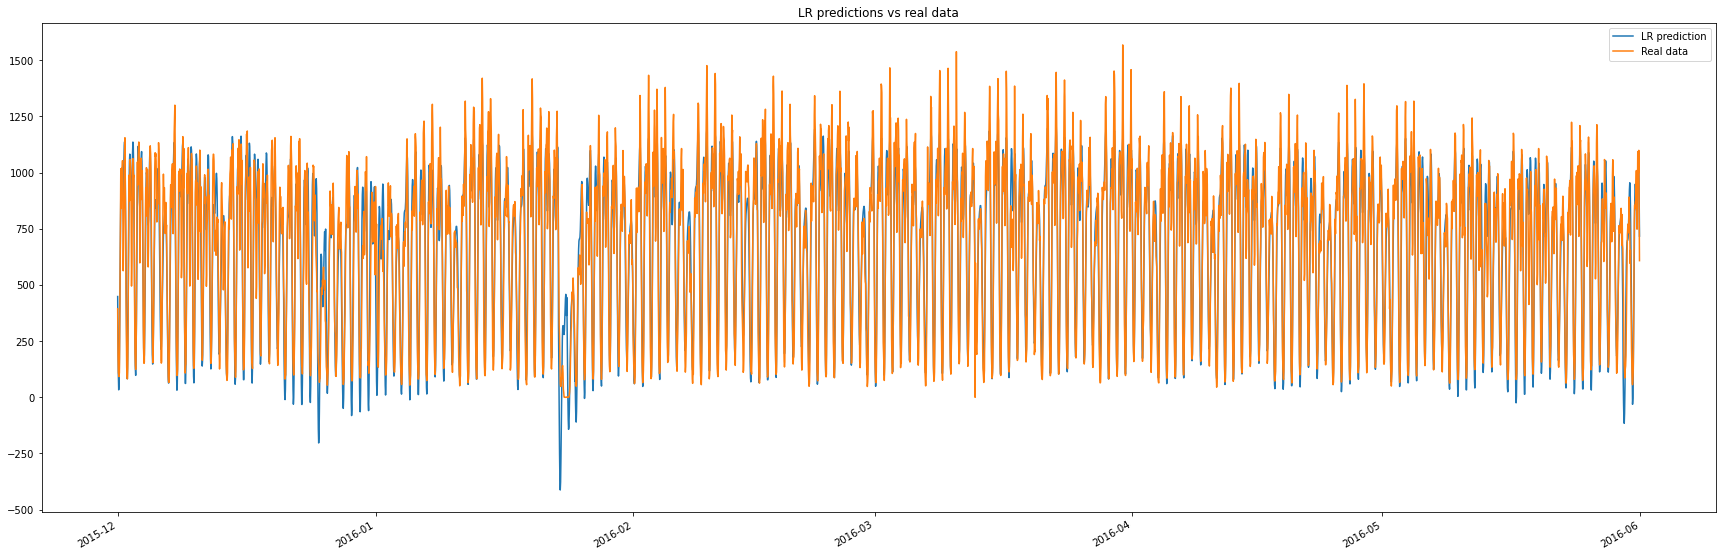

In [ ]:
fig = plt.figure(figsize=(30,10))
plt.plot(y.index, lr.predict(X), label='LR prediction')
y.plot(label='Real data', title='LR predictions vs real data')
plt.legend();

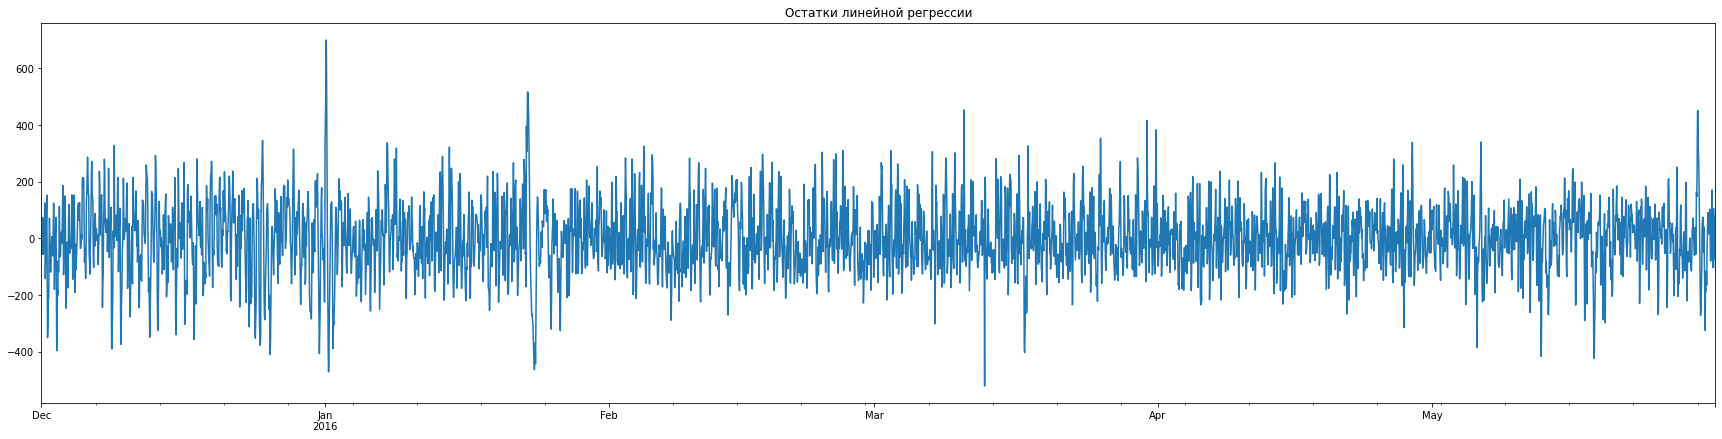

In [ ]:
fig = plt.figure(figsize=(30,7))
resid.plot(title='Остатки линейной регрессии');

Критерий Дики-Фуллера близок к нулю, поэтому смотрим на STL-декомпозицию остатков. 

Критерий Дики-Фуллера: p=0.000000


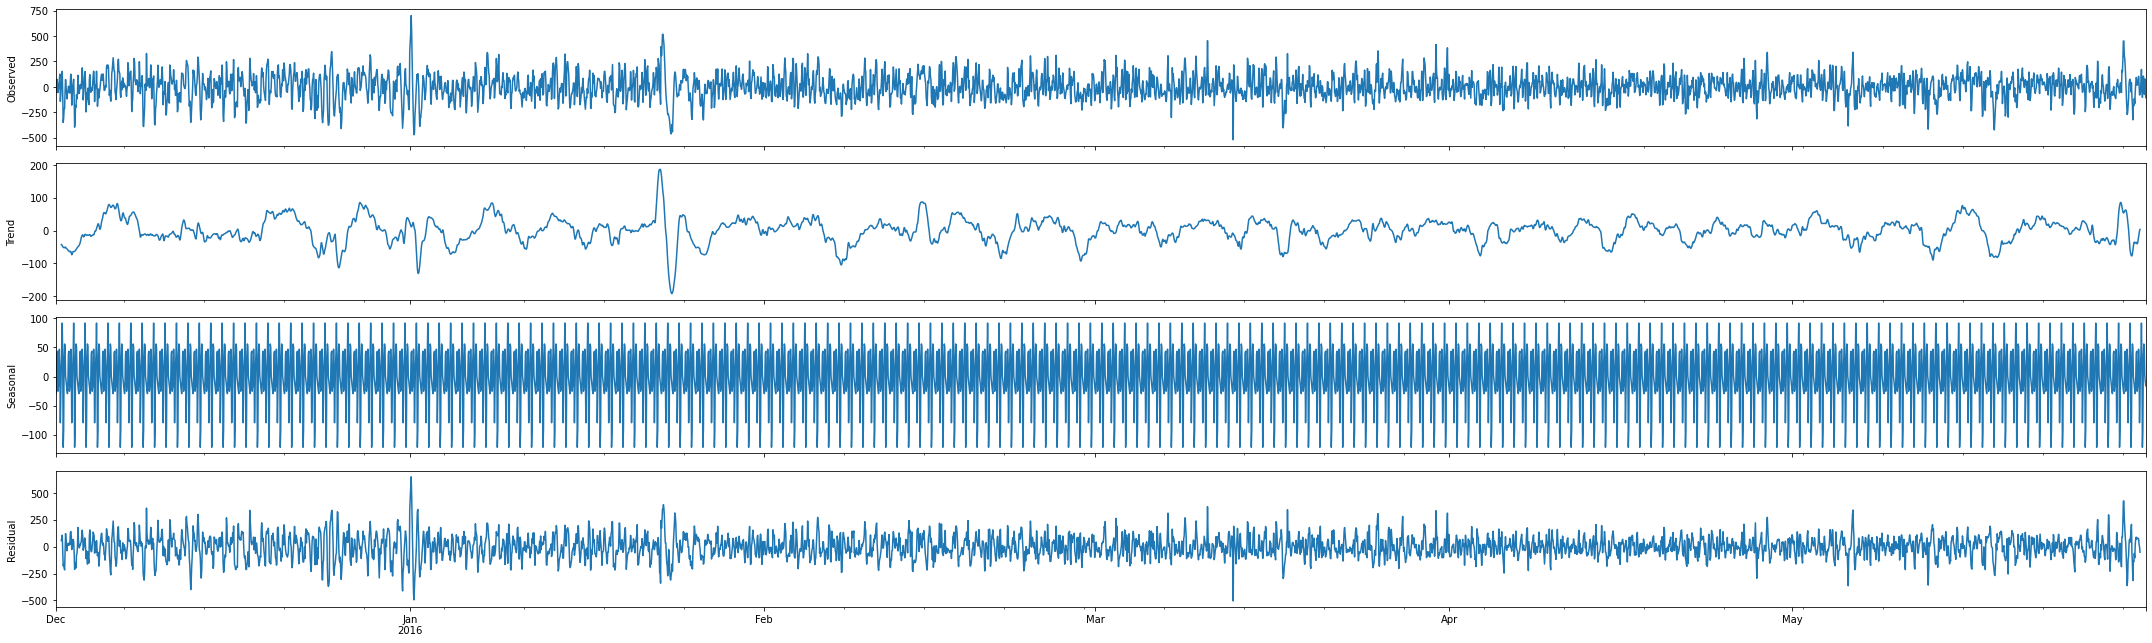

In [ ]:
plt.rcParams['figure.figsize'] = 30, 9
sm.tsa.seasonal_decompose(resid).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid)[1])

С помощью дифференциирования пробуем сделать ряд стационарным.

Критерий Дики-Фуллера: p=0.000000


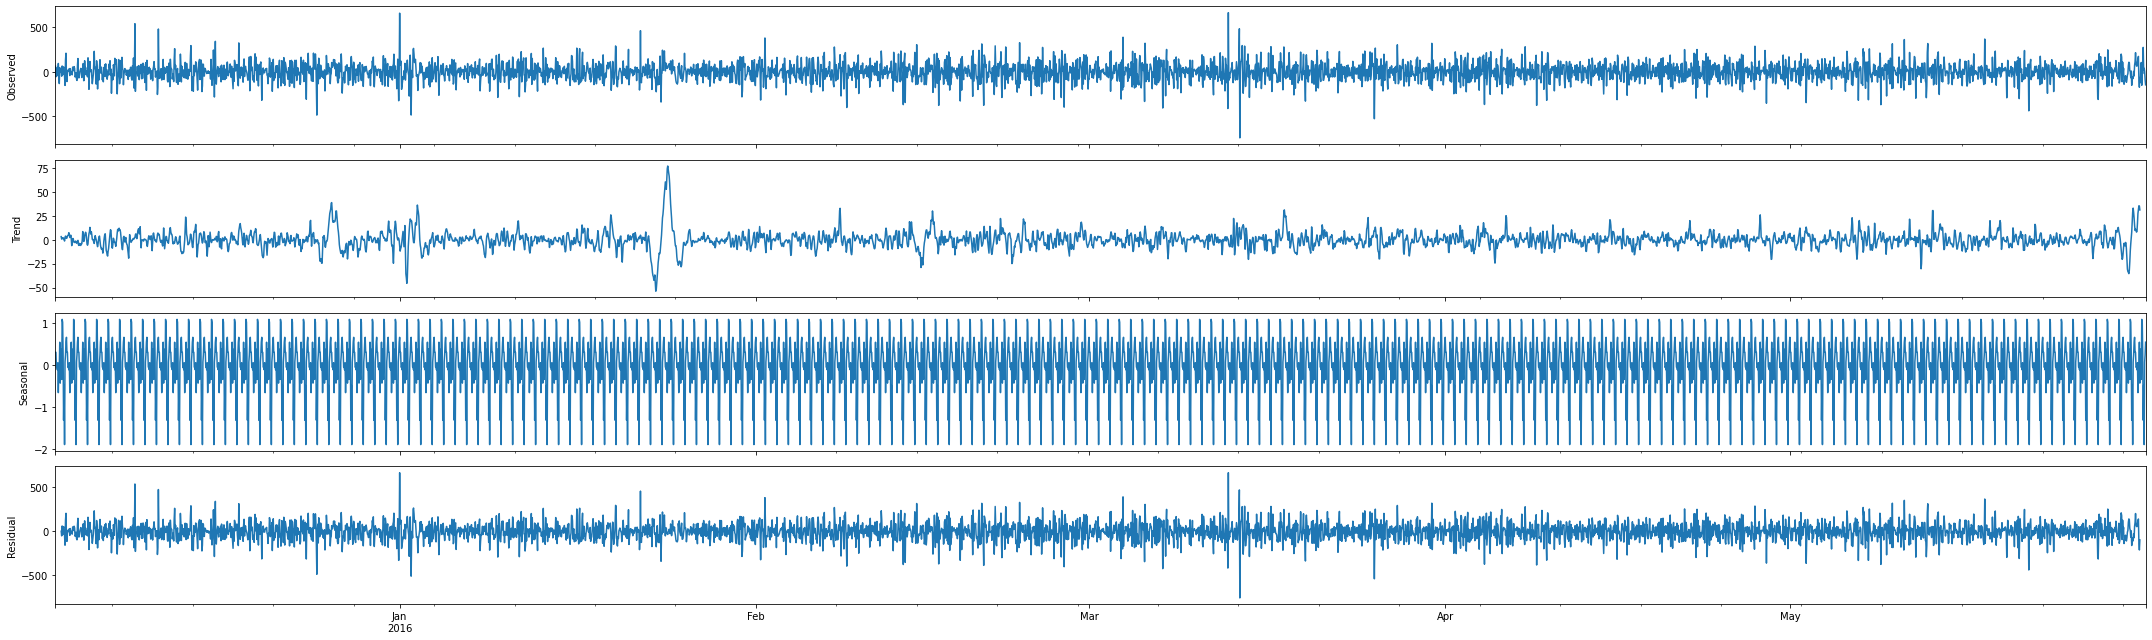

In [ ]:
plt.rcParams['figure.figsize'] = 30, 9
sm.tsa.seasonal_decompose(resid.diff(24).diff().dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid)[1])

#### Подбор модели

##### Посмотрим на ACF и PACF полученного ряда:

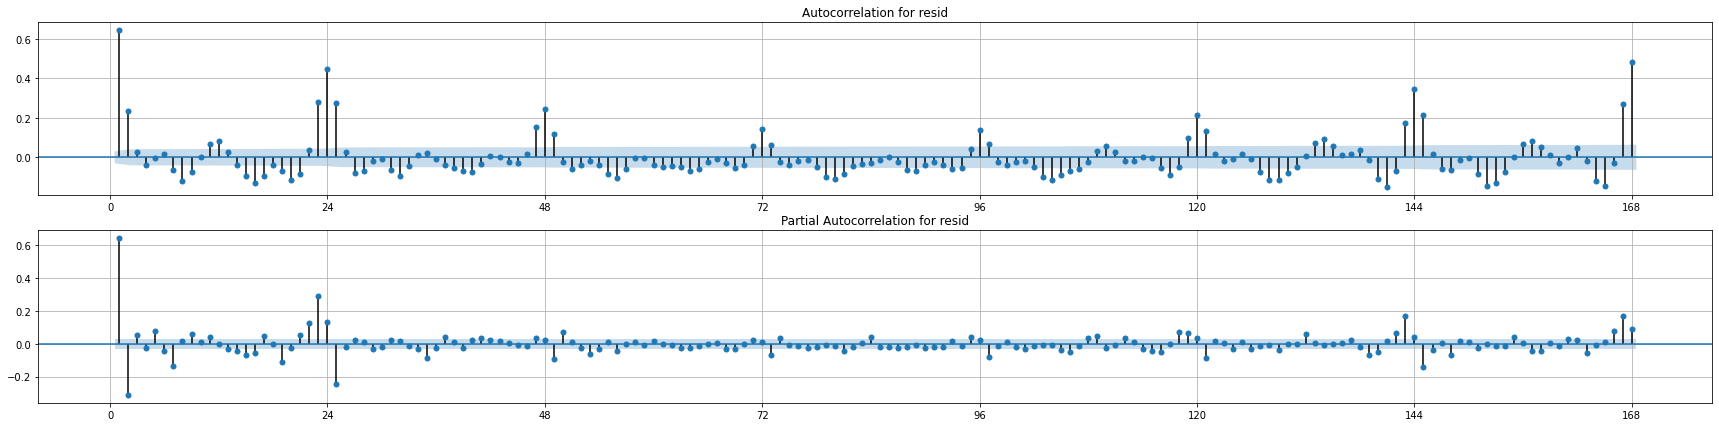

In [ ]:
resid_diff = resid

fig,ax = plt.subplots(2,1,figsize=(30,7))
fig = sm.graphics.tsa.plot_acf(resid_diff.values.squeeze(), lags=168, ax=ax[0], zero=False, title='Autocorrelation for resid')
ax[0].grid( True )
ax[0].set_xticks(np.arange(0, 169,24))
fig = sm.graphics.tsa.plot_pacf(resid_diff.values.squeeze(), lags=168, ax=ax[1], method='ywm', zero=False, title='Partial Autocorrelation for resid')
ax[1].grid( True )
ax[1].set_xticks(np.arange(0, 169,24))
plt.show()

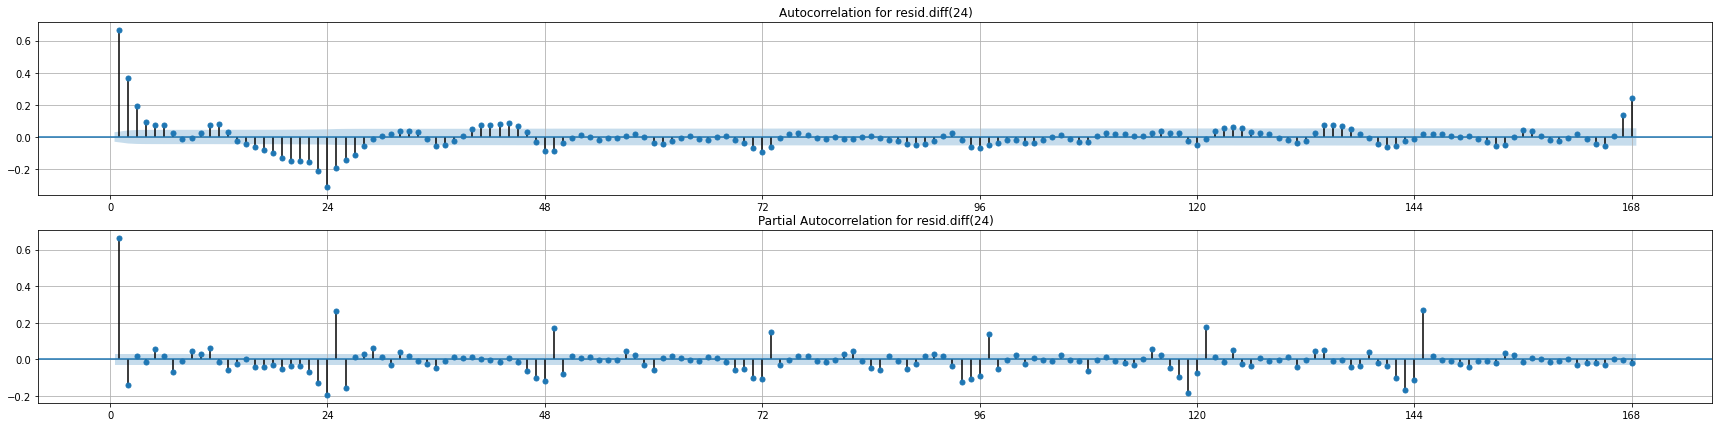

In [ ]:
resid_diff = resid.diff(24).dropna()

fig,ax = plt.subplots(2,1,figsize=(30,7))
fig = sm.graphics.tsa.plot_acf(resid_diff.values.squeeze(), lags=168, ax=ax[0], zero=False, title='Autocorrelation for resid.diff(24)')
ax[0].grid( True )
ax[0].set_xticks(np.arange(0, 169,24))
fig = sm.graphics.tsa.plot_pacf(resid_diff.values.squeeze(), lags=168, ax=ax[1], method='ywm', zero=False, title='Partial Autocorrelation for resid.diff(24)')
ax[1].grid( True )
ax[1].set_xticks(np.arange(0, 169,24))
plt.show()

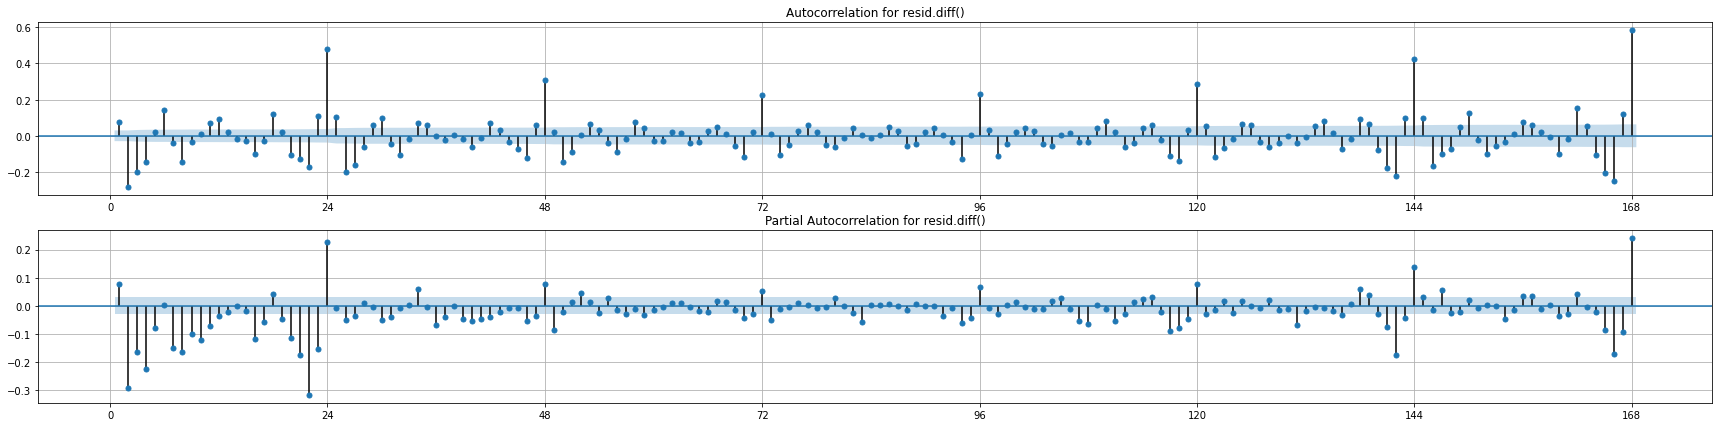

In [ ]:
resid_diff = resid.diff().dropna()

fig,ax = plt.subplots(2,1,figsize=(30,7))
fig = sm.graphics.tsa.plot_acf(resid_diff.values.squeeze(), lags=168, ax=ax[0], zero=False, title='Autocorrelation for resid.diff()')
ax[0].grid( True )
ax[0].set_xticks(np.arange(0, 169,24))
fig = sm.graphics.tsa.plot_pacf(resid_diff.values.squeeze(), lags=168, ax=ax[1], method='ywm', zero=False, title='Partial Autocorrelation for resid.diff()')
ax[1].grid( True )
ax[1].set_xticks(np.arange(0, 169,24))
plt.show()

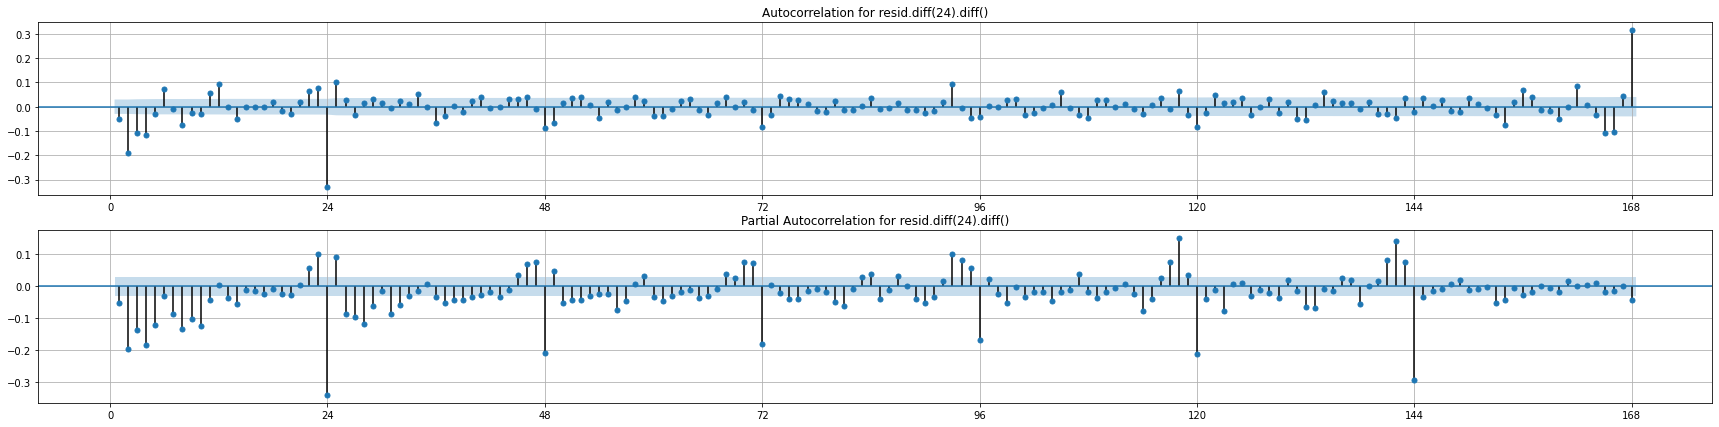

In [ ]:
resid_diff = resid.diff(24).diff().dropna()

fig,ax = plt.subplots(2,1,figsize=(30,7))
fig = sm.graphics.tsa.plot_acf(resid_diff.values.squeeze(), lags=168, ax=ax[0], zero=False, title='Autocorrelation for resid.diff(24).diff()')
ax[0].grid( True )
ax[0].set_xticks(np.arange(0, 169,24))
fig = sm.graphics.tsa.plot_pacf(resid_diff.values.squeeze(), lags=168, ax=ax[1], method='ywm', zero=False, title='Partial Autocorrelation for resid.diff(24).diff()')
ax[1].grid( True )
ax[1].set_xticks(np.arange(0, 169,24))
plt.show()

##### SARIMAX

Так же, как и в прошлый раз, находим : Q=4, q=0, P=2, p=2, D=1, d=0. Q =6-7 проверить не удалось, не хватает оперативной памяти.

In [19]:
ps = [2]
d=0
qs = [0]
Ps = [2]
D=1
Qs = [4]

In [20]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

1

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(resid, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        enforce_invertibility=False, enforce_stationarity=False).fit(disp=False)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters          aic
0  (2, 1, 2, 4)  48724.43905


Лучшая модель:

In [ ]:
mean_absolute_error(best_model.fittedvalues, resid)

52.80102345391422

In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 4392
Model:             SARIMAX(2, 0, 0)x(2, 1, 4, 24)   Log Likelihood              -24286.870
Date:                            Thu, 20 May 2021   AIC                          48591.739
Time:                                    18:01:59   BIC                          48648.976
Sample:                                12-01-2015   HQIC                         48611.961
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8442      0.014     59.934      0.000       0.817       0.872
ar.L2         -0.1638      0.017   

Её остатки:

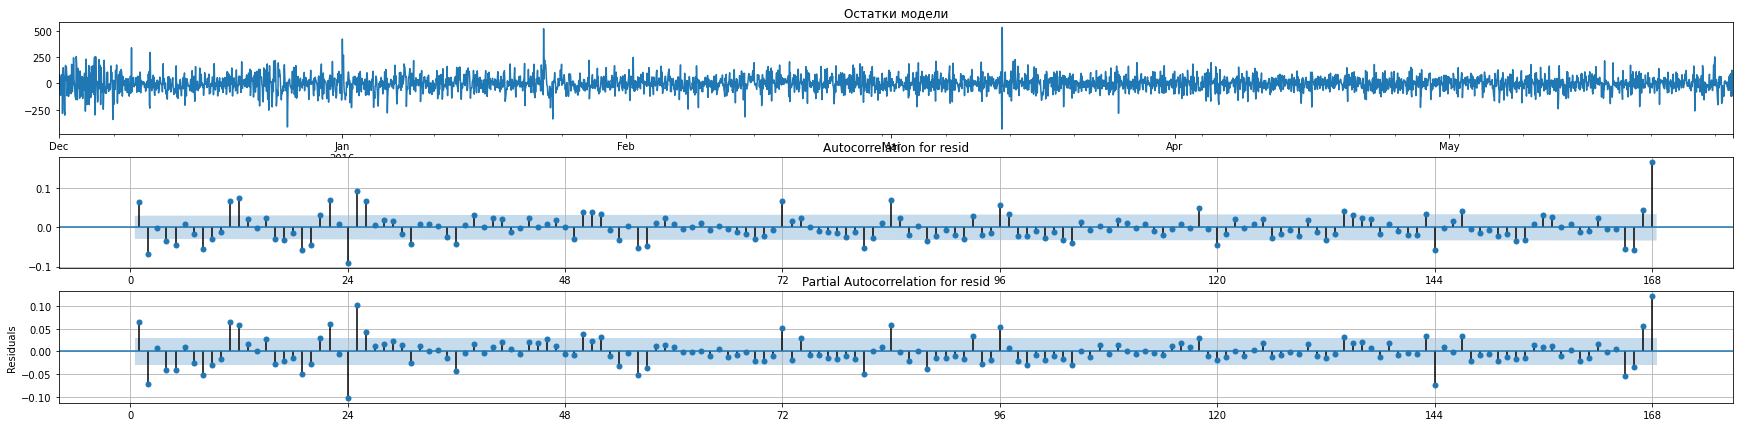

Критерий Стьюдента: p=0.456077
Критерий Дики-Фуллера: p=0.000000


In [18]:
fig,ax = plt.subplots(3,1,figsize=(30,7))

best_model.resid.plot(title='Остатки модели', ax=ax[0])
plt.ylabel(u'Residuals')


fig = sm.graphics.tsa.plot_acf(best_model.resid, lags=168, ax=ax[1], zero=False, title='Autocorrelation for resid')
ax[1].grid( True )
ax[1].set_xticks(np.arange(0, 169,24))
fig = sm.graphics.tsa.plot_pacf(best_model.resid, lags=168, ax=ax[2], method='ywm', zero=False, title='Partial Autocorrelation for resid')
ax[2].grid( True )
ax[2].set_xticks(np.arange(0, 169,24))
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Остатки не идеальны, но в рамках данной модели и ограниченности вычислительных ресурсов, большего добится не удалось
Посмотрим, насколько хорошо модель описывает данные:

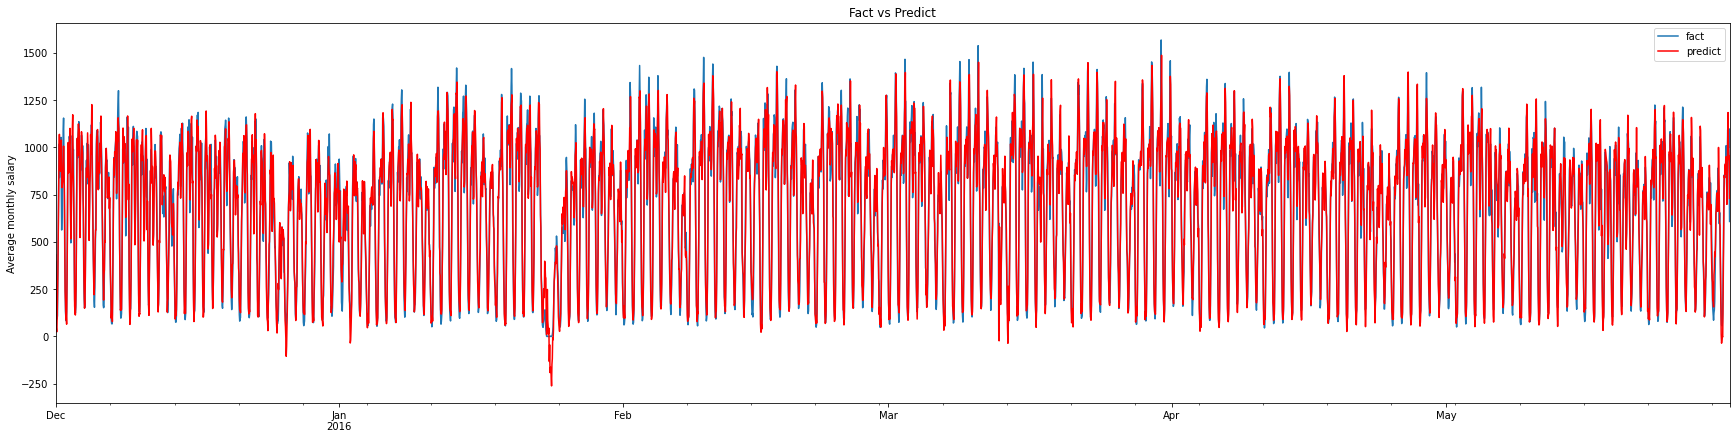

In [ ]:
prediction = best_model.fittedvalues + lr.predict(X)
plt.figure(figsize=(30,7))
y.plot(label = 'fact')
prediction.plot(color='r', label = 'predict', title='Fact vs Predict')
plt.ylabel('Average monthly salary')
plt.legend()
plt.show()

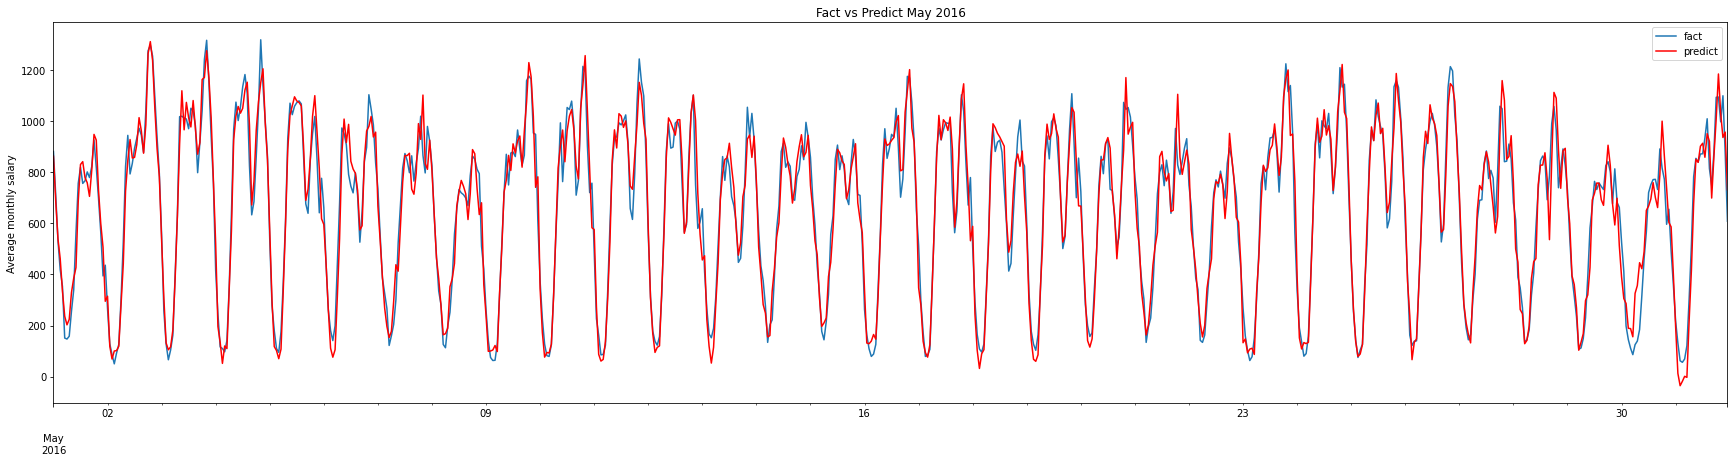

In [ ]:
plt.figure(figsize=(30,7))
y.iloc[-744:].plot(label = 'fact')
prediction.iloc[-744:].plot(color='r', label = 'predict', title='Fact vs Predict May 2016')
plt.ylabel('Average monthly salary')
plt.legend()
plt.show()

Модель плохо описывает данные в период снежной аномалии, в праздники "Рождество-Новый год". В предсказаниях есть отрицательные значения, немного можно улучшить результат, обнулив их. Можно добавить регрессионные признаки в дни до и после праздников.